# Segment and Convert  signals, then compare cleaning methods for each modality
Segment : cut the different acquisitions recorded in the same file (multi-run recordings).

Convert : change the file type (from `.acq` to `.hdf5`).

Cleaning : preparing signals for processing and confounds for fmri.

#### Dependencies

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import neurokit2 as nk2
import neurokit as nk
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [115]:
sns.set_style('darkgrid')
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 6.0)  
plt.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


## Utils contains functions that lists and segments biosignal acquisitions by run

In [14]:
%run ./convert_segments.py

<Figure size 864x432 with 0 Axes>

# Parse signals according to Trigger channel
Make a list of files for a single subject and cut it

`lastrec1` refers to friends task

In [10]:
ls = list_sub("C:/Users/sangfrois/Desktop/NeuroMod_tests/", sub='sub-03')

In [11]:
ls

{'ses-005': ['last-rec1.acq']}

[(6946612, 7241350), (10378450, 10408505), (13545607, 13590069), (16727171, 16768603), (19905705, 19954727), (23091830, 23087068)]
sub-03_ses-005_Run01 in file  last-rec1.acq 
in experiment: ses-005 is parsed. 
and saved at C:/Users/sangfrois/Desktop/NeuroMod_tests/samples-data/ | sampling rate is : 5000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-005_Run02 in file  last-rec1.acq 
in experiment: ses-005 is parsed. 
and saved at C:/Users/sangfrois/Desktop/NeuroMod_tests/samples-data/ | sampling rate is : 5000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-005_Run03 in file  last-rec1.acq 
in experiment: ses-005 is parsed. 
and saved at C:/Users/sangfrois/Desktop/NeuroMod_tests/samples-data/ | sampling rate is : 5000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-005_Run04 in file 

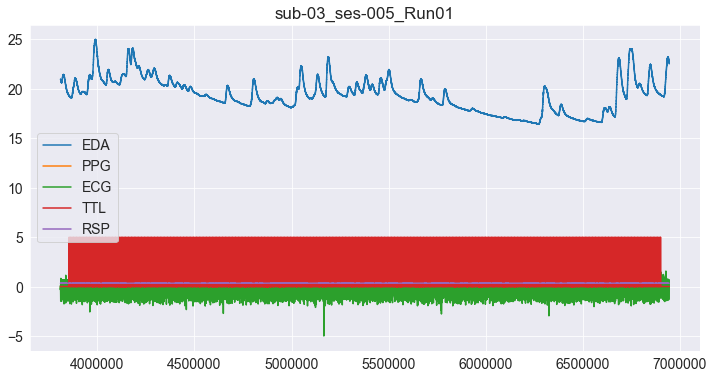

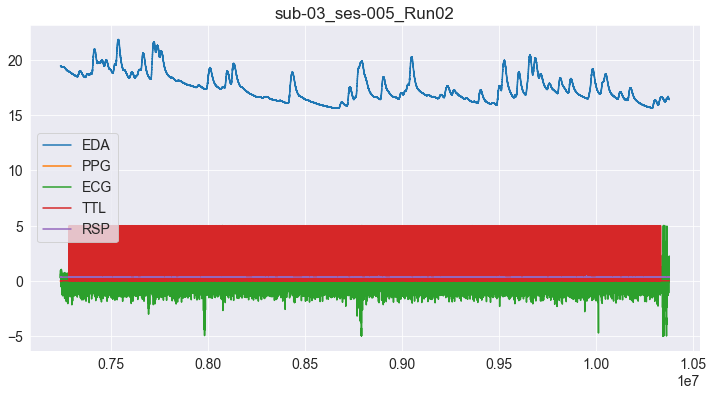

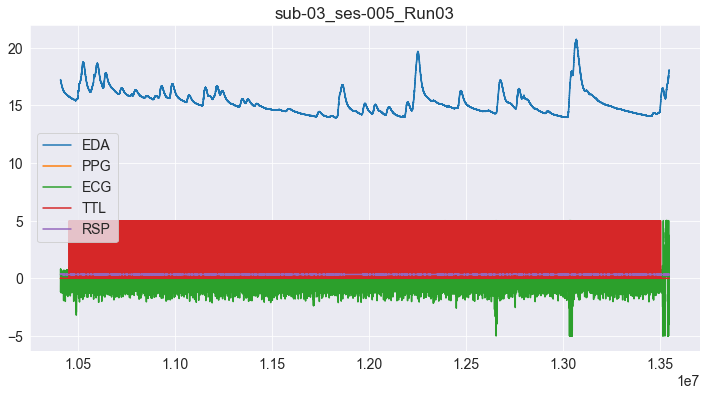

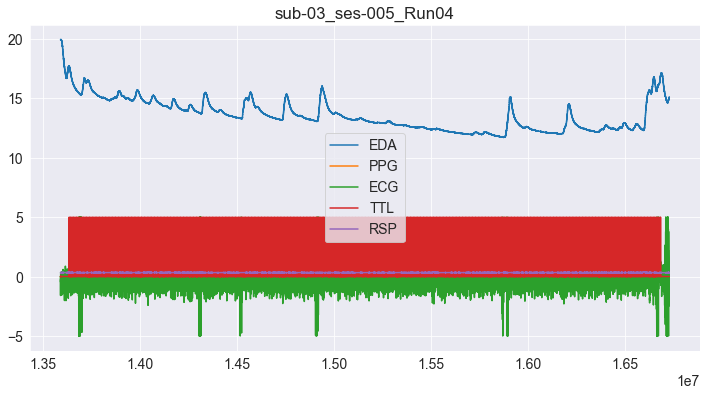

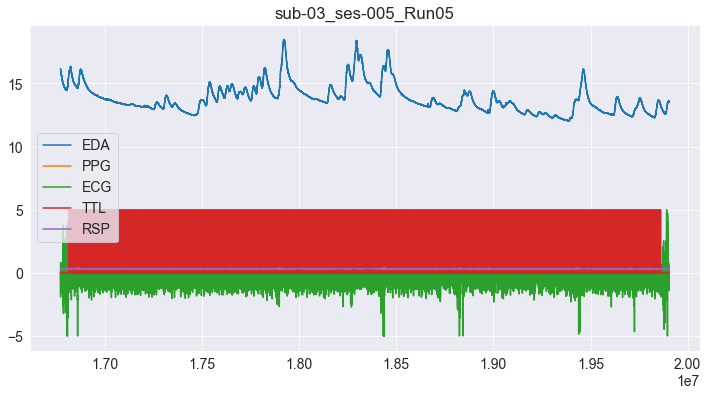

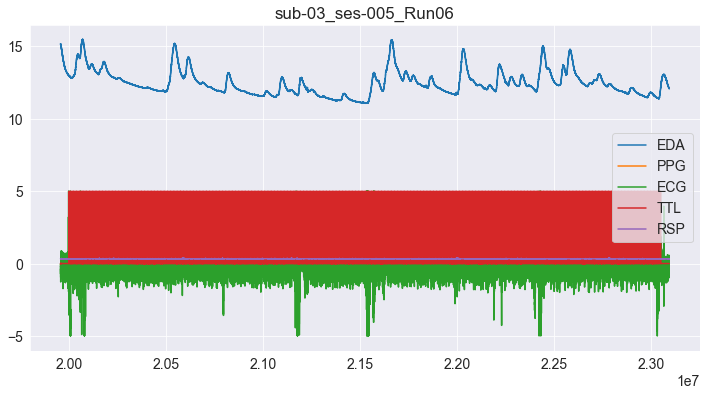

In [15]:
files = batch_parse("C:/Users/sangfrois/Desktop/NeuroMod_tests/", subject='sub-03', save_path="C:/Users/sangfrois/Desktop/NeuroMod_tests/samples-data/")

### Plot are saved along with the files
let's look at a run

In [4]:
bio_df = pd.read_csv('C:/Users/sangfrois/Desktop/NeuroMod_tests/samples-data/sub-03/sub-03_ses-005_Run01.tsv.gz', sep='t', compression='gzip')

column names are simpler and readable. They follow a convention... still to be made

In [5]:
bio_df.head()

,Unnamed: 0,EDA,PPG,ECG,TTL,RSP
0,3809508,20.954896,-0.042419,-0.301819,-0.000305,0.333862
1,3809509,20.954896,-0.042725,-0.300293,0.000000,0.332947
2,3809510,20.954896,-0.042419,-0.299377,-0.000305,0.334473
3,3809511,20.956421,-0.042114,-0.298309,-0.000305,0.334778
4,3809512,20.951844,-0.042419,-0.296936,0.000000,0.334778


## EDA

Text(0, 0.5, 'µSiemens')

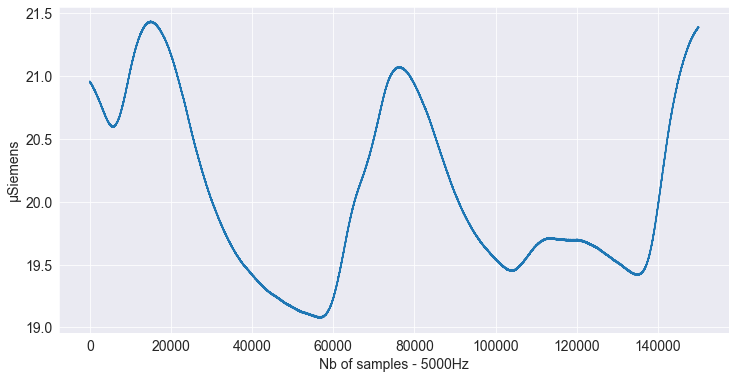

In [6]:
eda_raw = bio_df['EDA']
plt.plot(eda_raw[:150000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("µSiemens")

## Cleaning method specs
Lowpass - 5Hz (normalized freq)

Butterworth

order 4

smoothing convolution with boxzen kernel and window size of 0.75 * sampling_rate

In [7]:
eda_clean = nk2.eda_clean(eda_raw, 5000, method='biosppy')

### Plot 30 seconds

Text(0, 0.5, 'µSiemens')

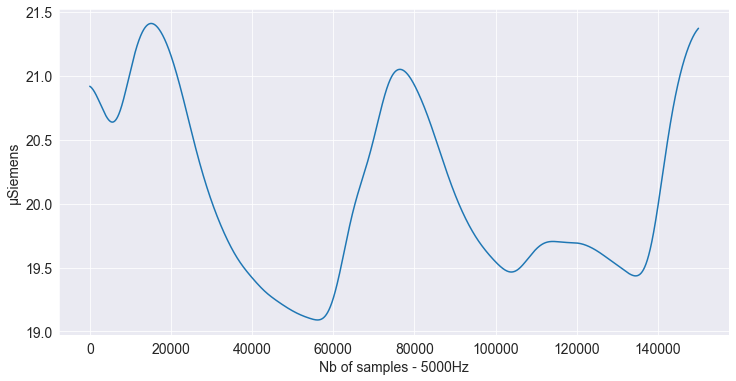

In [8]:
plt.plot(eda_clean[:150000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("µSiemens")

### Downsample
from 5000 Hz to 250 Hz

In [9]:
eda_down = nk2.signal_resample(eda_clean, sampling_rate=5000, desired_sampling_rate=250, method='interpolation')

Text(0, 0.5, 'µSiemens')

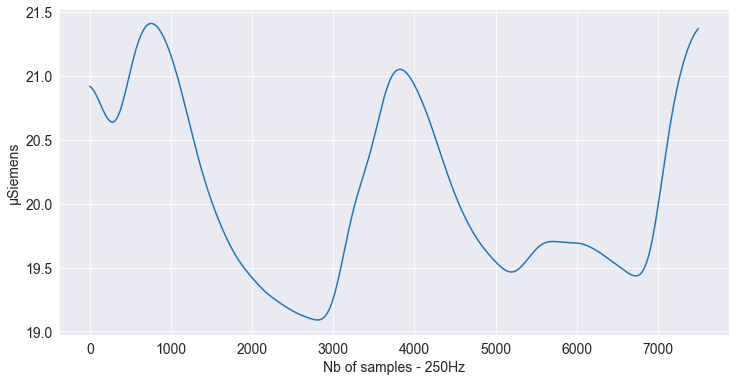

In [10]:
plt.plot(eda_down[:7500])
plt.xlabel("Nb of samples - 250Hz")
plt.ylabel("µSiemens")

### process with neurokit default pipeline

In [11]:
eda_proc, eda_info = nk2.eda_process(eda_down, sampling_rate=5000)

Text(0, 0.5, 'µSiemens')

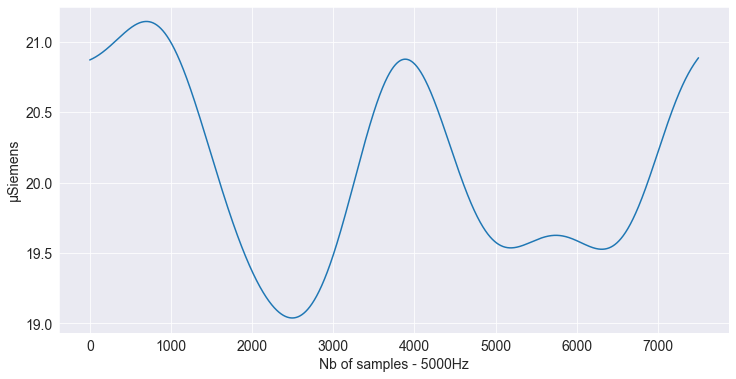

In [13]:
plt.plot(eda_proc['EDA_Clean'][:7500])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("µSiemens")

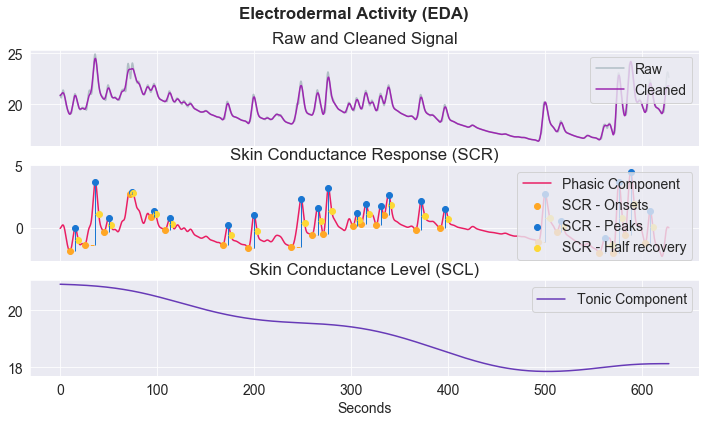

In [15]:
eda_fig = nk2.eda_plot(eda_proc, sampling_rate=250)

In [16]:
eda_info.keys()

dict_keys(['SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'])

# RSP

Text(0, 0.5, 'Volts')

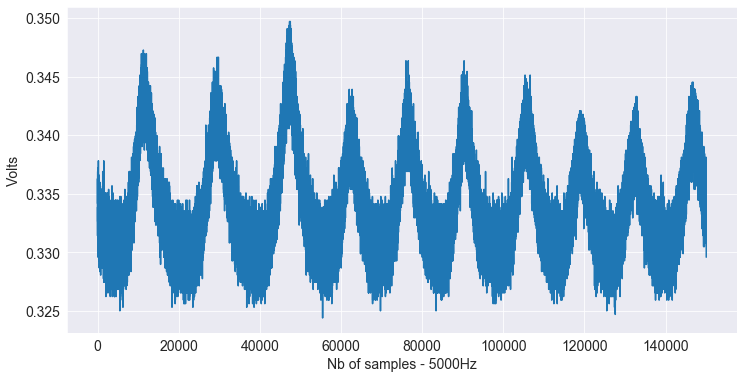

In [17]:
plt.plot(bio_df['RSP'][:150000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("Volts")

## Khodadad
Remove baseline by applying a lowcut at .05Hz (preserves breathing rates higher than 3 breath per minute) and high frequency noise by applying a highcut at 3 Hz (preserves breathing rates slower than 180 breath per minute).

In [19]:
rsp_clean = nk2.rsp_clean(bio_df['RSP'], sampling_rate=5000, method='khodadad2018')

Text(0, 0.5, 'Volts')

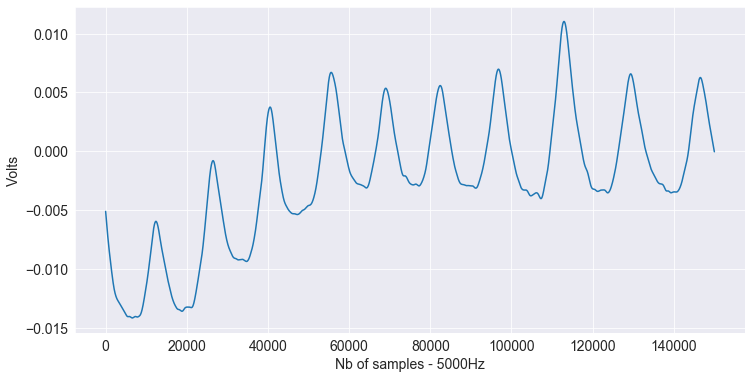

In [21]:
plt.plot(rsp_clean[50000:200000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("Volts")

## BioSPPy's method
second order [0.1 - 0.35 Hz] 

bandpass Butterworth filter

constant detrending


[docs](https://github.com/neuropsychology/NeuroKit/blob/master/neurokit2/rsp/rsp_clean.py)

In [22]:
rsp_clean1 = nk2.rsp_clean(bio_df['RSP'], sampling_rate=5000, method='biosppy')

Text(0, 0.5, 'Volts')

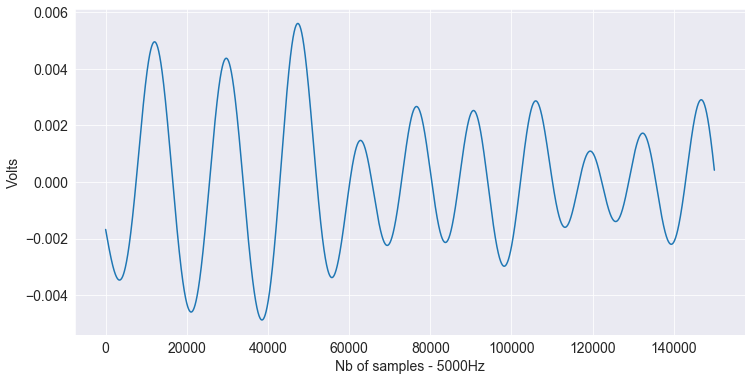

In [23]:
plt.plot(rsp_clean1[:150000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("Volts")

In [25]:
rsp_proc, rsp_info = nk2.rsp_process(bio_df['RSP'], sampling_rate=5000, method='khodadad2018')

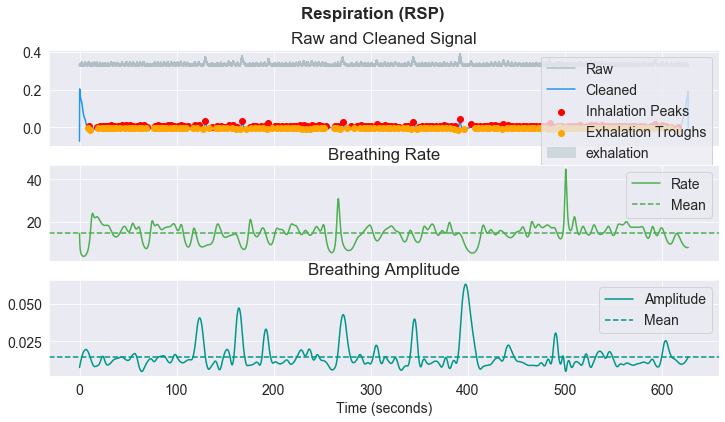

In [26]:
rsp_fig = nk2.rsp_plot(rsp_proc, sampling_rate=5000)

# PPG
unusable signal... should define minimal amplitude bracket to consider valid 

Text(0, 0.5, 'Volts')

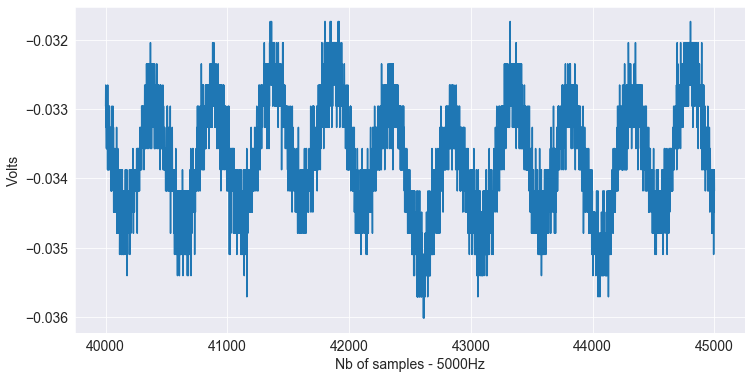

In [40]:
plt.plot(bio_df['PPG'][40000:45000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("Volts")

In [33]:
ppg_clean = nk2.ppg_clean(bio_df['PPG'], sampling_rate=5000)

Text(0, 0.5, 'Volts')

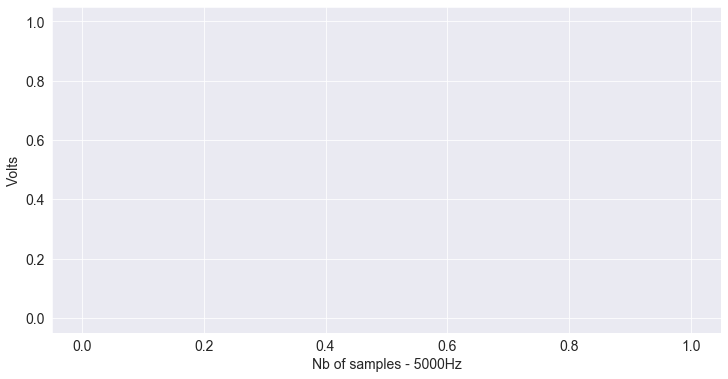

In [34]:
plt.plot(ppg_clean[20000:25000])
plt.xlabel("Nb of samples - 5000Hz")
plt.ylabel("Volts")

# ECG

In [45]:
ecg = bio_df['ECG']*-1

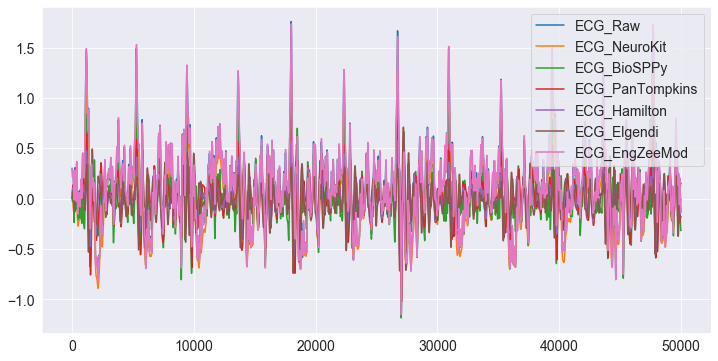

In [49]:
signals = pd.DataFrame({"ECG_Raw" : ecg,
"ECG_NeuroKit" : nk2.ecg_clean(ecg, sampling_rate=5000, method="neurokit"),
"ECG_BioSPPy" : nk2.ecg_clean(ecg, sampling_rate=5000, method="biosppy"),
"ECG_PanTompkins" : nk2.ecg_clean(ecg, sampling_rate=5000, method="pantompkins1985"),
"ECG_Hamilton" : nk2.ecg_clean(ecg, sampling_rate=5000, method="hamilton2002"),
"ECG_Elgendi" : nk2.ecg_clean(ecg, sampling_rate=5000, method="elgendi2010"),
"ECG_EngZeeMod" : nk2.ecg_clean(ecg, sampling_rate=5000, method="engzeemod2012")})
signals[:50000].plot()

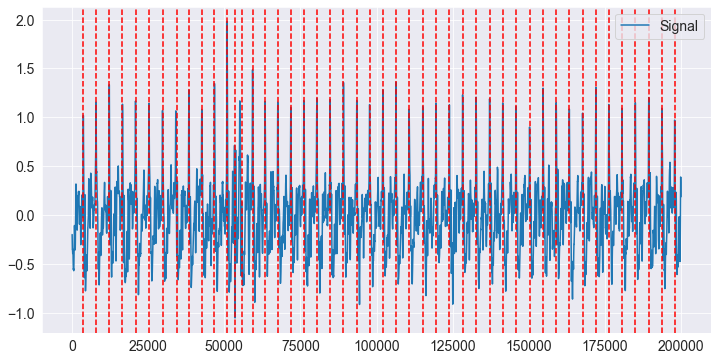

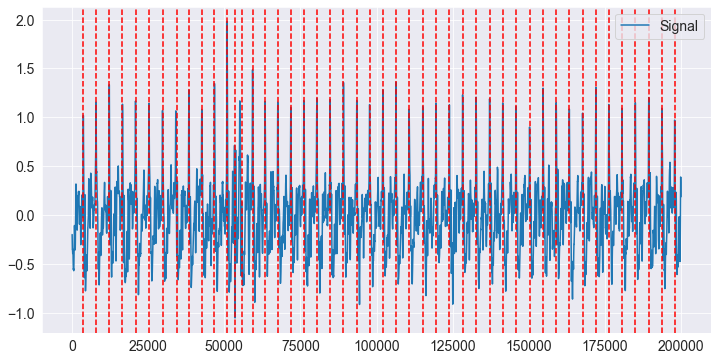

In [73]:
cleaned=signals['ECG_NeuroKit'][100000:300000]

info = nk2.ecg_findpeaks(np.array(cleaned),sampling_rate=5000)
nk2.events_plot(info["ECG_R_Peaks"], np.array(cleaned))

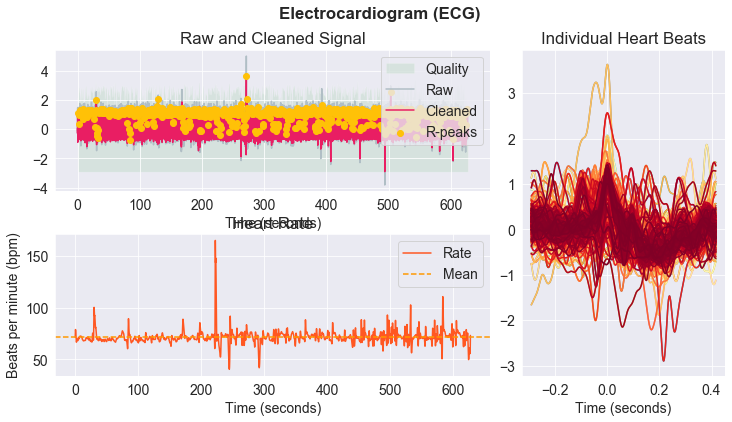

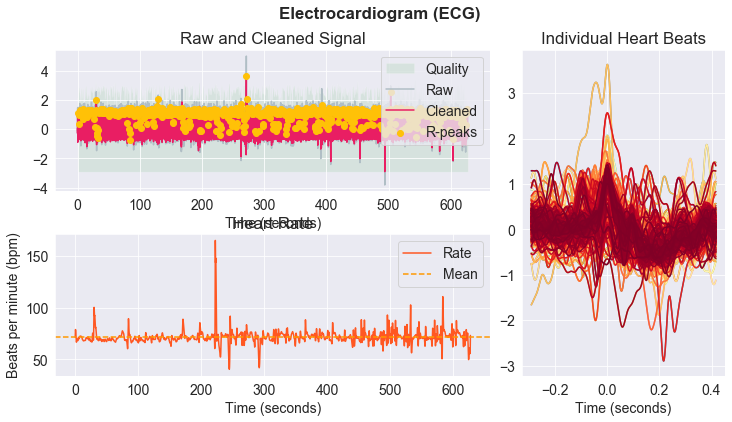

In [76]:
signals, info = nk2.ecg_process(ecg, sampling_rate=5000)
nk2.ecg_plot(signals, sampling_rate=5000, show_type='default')

In [104]:
from peakdet import operations, load_physio, Physio
data = Physio(np.array(cleaned), fs = 5000)

In [105]:
data

Physio(size=200000, fs=5000.0)

In [106]:
phys = operations.peakfind_physio(data)

In [107]:
phys.peaks

array([  1258,   3679,   6107,   7860,  10652,  12208,  15157,  16533,
        19093,  20819,  23586,  25252,  28086,  29691,  32506,  34042,
        36537,  38345,  40949,  42583,  45438,  46764,  49455,  50919,
        53346,  55078,  57615,  59275,  61824,  63388,  66004,  67559,
        70258,  71833,  74744,  76139,  79263,  80393,  83190,  84757,
        87691,  89155,  93524,  97729, 100538, 102079, 104591, 106379,
       109064, 110728, 115187, 117039, 119542, 122383, 123950, 126455,
       128284, 130853, 132729, 135341, 137152, 139732, 141465, 144258,
       145847, 148758, 150287, 153175, 154740, 156593, 159047, 161124,
       163353, 166122, 167691, 170621, 172079, 174038, 176325, 179074,
       180658, 183559, 185043, 187968, 189451, 192011, 193749, 196413,
       197960, 199940], dtype=int64)

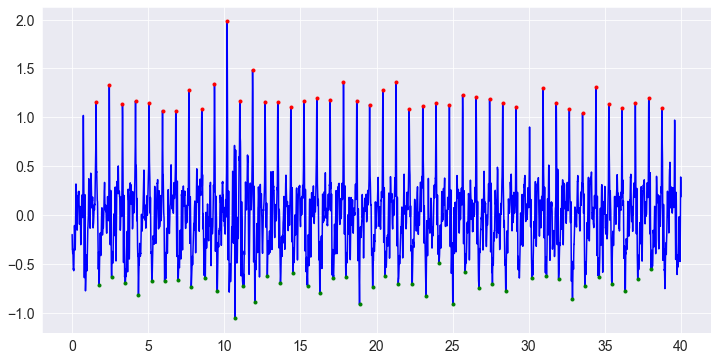

In [109]:
data = operations.peakfind_physio(data, thresh=0.8, dist=100)
ax = operations.plot_physio(data)

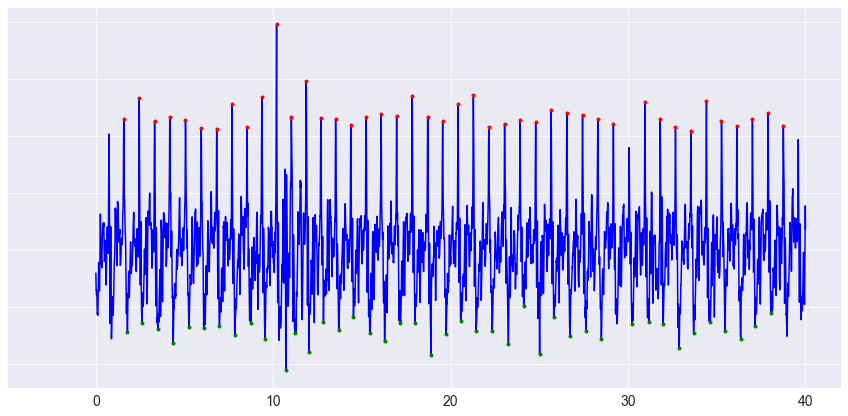

Physio(size=200000, fs=5000.0)

In [117]:
operations.edit_physio(data)